# Prediksi Performa Antena Mikrostrip FR-4 10 GHz dengan Deep Neural Network
Notebook ini dibuat agar dapat dijalankan langsung di Google Colab.
Model multi-output memprediksi Gain (dBi), S11 (dB), dan Efisiensi (%) berdasarkan parameter geometris.

Jalankan semua sel berurutan (Runtime > Run all).

In [ ]:
# Jika menjalankan di Google Colab, jalankan baris ini untuk memastikan paket terpasang
# (di lingkungan lokal, pastikan tensorflow, scikit-learn, pandas, matplotlib sudah terinstall)
try:
    import tensorflow as tf
    print('TensorFlow versi:', tf.__version__)
except Exception as e:
    print('Menginstall dependensi...')
    #!pip install -q tensorflow scikit-learn pandas matplotlib
    import tensorflow as tf
    print('TensorFlow versi:', tf.__version__)


2025-11-18 09:11:20.903378: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-18 09:11:20.960870: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-18 09:11:22.330413: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


TensorFlow versi: 2.20.0


## 1. Muat Dataset
Upload file `dataset_antenna_radar10GHz_FR4_100.csv` ke Colab (sidebar kiri -> Files -> Upload) atau letakkan di folder yang sama. Setelah itu jalankan sel berikut:

In [1]:
import pandas as pd
import os

# Nama file dataset (pastikan sudah diupload ke runtime Colab)
DATASET = 'dataset_patch_antenna_microstrip_500rows.csv'
if not os.path.exists(DATASET):
    print('File dataset tidak ditemukan di runtime. Silakan upload dataset_antenna_radar10GHz_FR4_100.csv ke Colab.')
else:
    df = pd.read_csv(DATASET)
    print('Dataset berhasil dimuat. Ukuran dataset:', df.shape)
    display(df.head())

# Simpan variabel df untuk sel-sel selanjutnya


Dataset berhasil dimuat. Ukuran dataset: (500, 11)


,panjang_patch_mm,lebar_patch_mm,tebal_substrat_mm,epsilon_r,persentase_FR4,persentase_Rogers,frekuensi_resonansi_GHz,S11_dB,Gain_dBi,bandwidth_MHz,efisiensi_persen
0,25.246,30.661,1.6,3.52,60,40,3.1093,-33.37,3.73,151.42,68.72
1,29.216,36.239,1.6,3.08,40,60,2.8714,-29.34,4.79,170.76,68.16
2,36.171,43.790,1.6,2.20,0,100,2.7341,-34.13,6.71,272.32,90.43
3,38.400,51.645,1.6,3.96,80,20,1.9428,-15.16,5.22,77.08,60.19
4,27.392,35.831,1.6,3.52,60,40,2.8655,-32.06,4.08,125.91,67.66


## 2. Pra-pemrosesan Data
Normalisasi input & output, serta pembagian data training/testing (80/20).

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Pastikan df sudah terdefinisi (hasil dari sel sebelumnya)
try:
    df
except NameError:
    raise NameError('DataFrame df tidak ditemukan. Muat dataset terlebih dahulu.')

# Pilih fitur (input) dan target (output)
features = ['panjang_patch_mm','lebar_patch_mm','tebal_substrat_mm','epsilon_r','bandwidth_MHz']
targets = ['frekuensi_resonansi_GHz','Gain_dBi','S11_dB','efisiensi_persen']

# Pastikan kolom ada
missing = [c for c in features+targets if c not in df.columns]
if missing:
    raise ValueError(f'Kolom berikut tidak ditemukan di dataset: {missing}')

X = df[features].values.astype(float)
y = df[targets].values.astype(float)

# Normalisasi
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
print('Split data selesai. Train:', X_train.shape, 'Test:', X_test.shape)


Split data selesai. Train: (400, 5) Test: (100, 5)


## 3. Membangun Model DNN (Multi-output)
Model dengan dropout dan konfigurasi hyperparameter sederhana.

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def build_model(input_dim, output_dim, units=[128,64,32], dropout=0.15, lr=1e-3):
    model = Sequential()
    model.add(Dense(units[0], activation='relu', input_shape=(input_dim,)))
    model.add(Dropout(dropout))
    for u in units[1:]:
        model.add(Dense(u, activation='relu'))
    model.add(Dense(output_dim, activation='linear'))
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='mse', metrics=['mae'])
    return model

# Contoh pembuatan model
model = build_model(X_train.shape[1], y_train.shape[1], units=[128,64,32], dropout=0.15, lr=1e-3)
model.summary()


2025-11-21 05:05:46.126609: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-21 05:05:47.212473: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-21 05:05:55.162300: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/myenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,236 (43.89 KB)

 Trainable params: 11,236 (43.89 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Pelatihan Model
Pelatihan dengan early stopping dan menyimpan model terbaik sebagai `antenna_model_best.h5`. Silakan atur `epochs` sesuai kebutuhan.

In [5]:
# Callback untuk menyimpan model terbaik
checkpoint_path = 'antenna_model_best.h5'
mc = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

es = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)

history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=8, callbacks=[es, mc], verbose=1)

print('Pelatihan selesai. Model terbaik tersimpan di:', checkpoint_path)


Epoch 1/100


2025-11-21 05:06:17.398452: I external/local_xla/xla/service/service.cc:163] XLA service 0x77022800a910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-21 05:06:17.398570: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-11-21 05:06:17.456551: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-21 05:06:17.844333: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


26/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2109 - mae: 0.3871

I0000 00:00:1763676380.824334    4118 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1763 - mae: 0.3462
Epoch 1: val_loss improved from None to 0.03758, saving model to antenna_model_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.1141 - mae: 0.2714 - val_loss: 0.0376 - val_mae: 0.1516
Epoch 2/100
40/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0423 - mae: 0.1667
Epoch 2: val_loss improved from 0.03758 to 0.02391, saving model to antenna_model_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0369 - mae: 0.1532 - val_loss: 0.0239 - val_mae: 0.1162
Epoch 3/100
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0260 - mae: 0.1225
Epoch 3: val_loss improved from 0.02391 to 0.02045, saving model to antenna_model_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0242 - mae: 0.1176 - val_loss: 0.0205 - val_mae: 0.0997
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0226 - mae: 0.1092
Epoch 4: val_loss did not improve from 0.02045
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0224 - mae: 0.1079 - val_loss: 0.0211 - val_mae: 0.0987
Epoch 5/100
42/45 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0217 - mae: 0.1048
Epoch 5: val_loss improved from 0.02045 to 0.02024, saving model to antenna_model_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0213 - mae: 0.1038 - val_loss: 0.0202 - val_mae: 0.0955
Epoch 6/100
36/45 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0226 - mae: 0.1059
Epoch 6: val_loss did not improve from 0.02024
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0215 - mae: 0.1054 - val_loss: 0.0206 - val_mae: 0.0971
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0203 - mae: 0.1014
Epoch 7: val_loss did not improve from 0.02024
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0210 - mae: 0.1022 - val_loss: 0.0205 - val_mae: 0.0984
Epoch 8/100
41/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0214 - mae: 0.1010
Epoch 8: val_loss improved from 0.02024 to 0.01952, saving model to antenna_model_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0207 - mae: 0.1009 - val_loss: 0.0195 - val_mae: 0.0959
Epoch 9/100
43/45 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0205 - mae: 0.1016
Epoch 9: val_loss did not improve from 0.01952
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0209 - mae: 0.1003 - val_loss: 0.0202 - val_mae: 0.0985
Epoch 10/100
39/45 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0202 - mae: 0.1006
Epoch 10: val_loss did not improve from 0.01952
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0201 - mae: 0.1001 - val_loss: 0.0198 - val_mae: 0.0976
Epoch 11/100
43/45 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0207 - mae: 0.1003
Epoch 11: val_loss improved from 0.01952 to 0.01905, saving model to antenna_model_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0201 - mae: 0.0996 - val_loss: 0.0190 - val_mae: 0.0921
Epoch 12/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0200 - mae: 0.0995
Epoch 12: val_loss did not improve from 0.01905
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0194 - mae: 0.0973 - val_loss: 0.0193 - val_mae: 0.0936
Epoch 13/100
42/45 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0200 - mae: 0.0979
Epoch 13: val_loss did not improve from 0.01905
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0196 - mae: 0.0968 - val_loss: 0.0194 - val_mae: 0.0929
Epoch 14/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0201 - mae: 0.0978
Epoch 14: val_loss did not improve from 0.01905
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0198 - mae: 0.0970 - val_loss: 0.0214 - val_mae: 0.0943
Epoch 15/100
42/45 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0194 - mae: 0.0972
Epoch 15: val_loss did not improve from 0.01905
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0204 -

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0193 - mae: 0.0950 - val_loss: 0.0188 - val_mae: 0.0908
Epoch 20/100
42/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0195 - mae: 0.0962
Epoch 20: val_loss did not improve from 0.01883
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0194 - mae: 0.0967 - val_loss: 0.0192 - val_mae: 0.0911
Epoch 21/100
42/45 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0214 - mae: 0.1008
Epoch 21: val_loss did not improve from 0.01883
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0202 - mae: 0.0987 - val_loss: 0.0192 - val_mae: 0.0918
Epoch 22/100
43/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0188 - mae: 0.0944
Epoch 22: val_loss did not improve from 0.01883
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0189 - mae: 0.0945 - val_loss: 0.0194 - val_mae: 0.0919
Epoch 23/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0186 - mae: 0.0933
Epoch 23: val_loss did not improve from 0.01883
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0189 - ma

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0190 - mae: 0.0942 - val_loss: 0.0188 - val_mae: 0.0897
Epoch 26/100
43/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0196 - mae: 0.0938
Epoch 26: val_loss did not improve from 0.01876
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0195 - mae: 0.0945 - val_loss: 0.0196 - val_mae: 0.0913
Epoch 27/100
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0188 - mae: 0.0941
Epoch 27: val_loss did not improve from 0.01876
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0188 - mae: 0.0940 - val_loss: 0.0190 - val_mae: 0.0905
Epoch 28/100
43/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0192 - mae: 0.0943
Epoch 28: val_loss did not improve from 0.01876
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0186 - mae: 0.0930 - val_loss: 0.0194 - val_mae: 0.0903
Epoch 29/100
43/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0189 - mae: 0.0952
Epoch 29: val_loss did not improve from 0.01876
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0186 -

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0182 - mae: 0.0909 - val_loss: 0.0188 - val_mae: 0.0887
Epoch 36/100
41/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0185 - mae: 0.0918
Epoch 36: val_loss did not improve from 0.01876
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0183 - mae: 0.0911 - val_loss: 0.0211 - val_mae: 0.0940
Epoch 37/100
43/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0188 - mae: 0.0919
Epoch 37: val_loss did not improve from 0.01876
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0187 - mae: 0.0921 - val_loss: 0.0190 - val_mae: 0.0896
Epoch 38/100
35/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0171 - mae: 0.0898
Epoch 38: val_loss did not improve from 0.01876
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0185 - mae: 0.0923 - val_loss: 0.0189 - val_mae: 0.0892
Epoch 39/100
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0185 - mae: 0.0929
Epoch 39: val_loss did not improve from 0.01876
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0186 - mae: 

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0181 - mae: 0.0902 - val_loss: 0.0188 - val_mae: 0.0890
Epoch 46/100
40/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0179 - mae: 0.0894
Epoch 46: val_loss did not improve from 0.01875
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0183 - mae: 0.0909 - val_loss: 0.0190 - val_mae: 0.0889
Epoch 47/100
41/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0173 - mae: 0.0874
Epoch 47: val_loss did not improve from 0.01875
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0180 - mae: 0.0900 - val_loss: 0.0189 - val_mae: 0.0909
Epoch 48/100
40/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0188 - mae: 0.0904
Epoch 48: val_loss did not improve from 0.01875
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0184 - mae: 0.0906 - val_loss: 0.0191 - val_mae: 0.0908
Epoch 49/100
42/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0191 - mae: 0.0915
Epoch 49: val_loss did not improve from 0.01875
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0184 - mae:

## 5. Evaluasi Model & Visualisasi
Menampilkan grafik Loss dan scatter plot Prediksi vs Aktual untuk Gain, S11, dan Efisiensi.

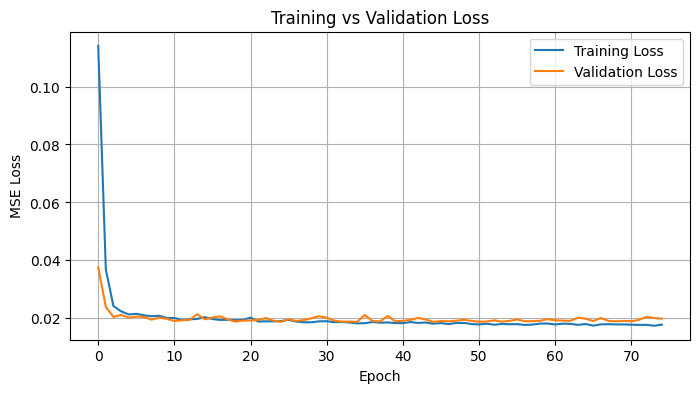

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step


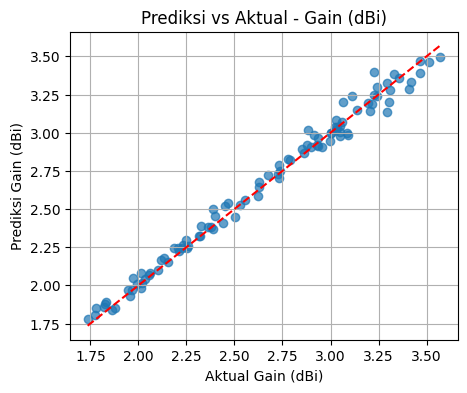

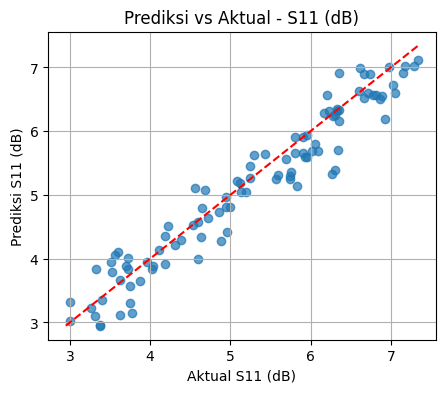

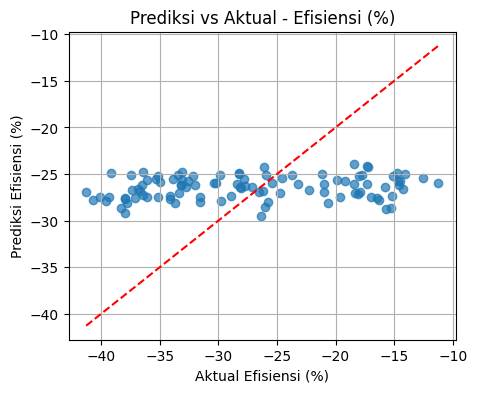

,akt_frekuensi_resonansi_GHz,akt_Gain_dBi,akt_S11_dB,akt_efisiensi_persen,pred_frekuensi_resonansi_GHz,pred_Gain_dBi,pred_S11_dB,pred_efisiensi_persen
0,3.0651,4.31,-39.29,75.19,3.198367,4.220893,-27.469797,70.985138
1,2.8811,3.78,-23.69,56.88,3.020294,3.152106,-25.128254,56.515831
2,3.4065,4.18,-20.98,71.69,3.283867,3.909712,-26.916084,67.140144
3,3.2419,3.75,-33.88,56.95,3.237761,3.569364,-25.522015,61.209229
4,1.8246,5.20,-28.27,53.43,1.876063,5.047733,-24.879200,58.021564
5,3.0498,5.57,-36.85,85.23,3.004989,5.248063,-26.621456,79.615150
6,1.8334,6.28,-20.68,75.73,1.888852,6.240105,-28.100113,78.361656
7,3.0470,5.74,-32.78,83.53,2.981217,5.300733,-26.399345,79.501404
8,1.8207,6.67,-15.72,85.34,1.856145,6.893113,-28.708839,86.426338
9,3.2248,4.96,-28.88,73.06,3.398618,4.421916,-27.366791,75.232925


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Plot training history
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.grid(True)
plt.show()

# Load best model
from tensorflow.keras.models import load_model

# Tambahkan 'compile=False'
best_model = load_model(checkpoint_path, compile=False) 

# Prediksi pada test set
y_pred_scaled = best_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_orig = scaler_y.inverse_transform(y_test)

# Fungsi bantu plotting
def scatter_pred_actual(idx, label):
    plt.figure(figsize=(5,4))
    plt.scatter(y_test_orig[:,idx], y_pred[:,idx], alpha=0.7)
    mn = min(y_test_orig[:,idx].min(), y_pred[:,idx].min())
    mx = max(y_test_orig[:,idx].max(), y_pred[:,idx].max())
    plt.plot([mn,mx],[mn,mx], 'r--')
    plt.xlabel(f'Aktual {label}')
    plt.ylabel(f'Prediksi {label}')
    plt.title(f'Prediksi vs Aktual - {label}')
    plt.grid(True)
    plt.show()

# 0: Gain, 1: S11, 2: Efisiensi
scatter_pred_actual(0, 'Gain (dBi)')
scatter_pred_actual(1, 'S11 (dB)')
scatter_pred_actual(2, 'Efisiensi (%)')

# Tampilkan beberapa nilai prediksi vs aktual
result_df = pd.DataFrame(np.hstack([y_test_orig, y_pred]), columns=[f'akt_{c}' for c in targets] + [f'pred_{c}' for c in targets])
display(result_df.head(10))


## 6. Simpan Hasil & Unduh
Menyimpan model (.h5) dan grafik ke file PNG di runtime. Gunakan sidebar Files di Colab untuk mengunduh.

Gambar saved: training_loss.png
Gambar saved: pred_vs_actual_gain.png

Jika ingin mengunduh semua file, buka sidebar kiri di Colab -> Files -> klik kanan file -> Download.


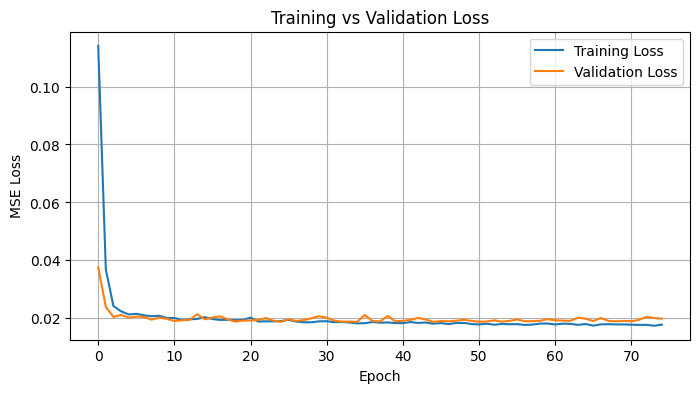

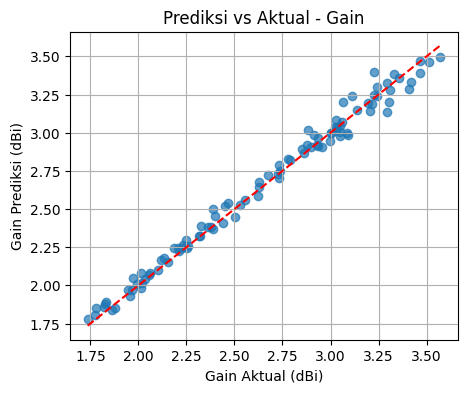

In [8]:
# Simpan model sudah dilakukan oleh ModelCheckpoint.
# Simpan contoh grafik ke file lokal
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('MSE Loss'); plt.legend(); plt.grid(True)
plt.title('Training vs Validation Loss')
plt.savefig('training_loss.png', dpi=200)
print('Gambar saved: training_loss.png')

# Simpan prediksi vs aktual gain sebagai contoh
plt.figure(figsize=(5,4))
plt.scatter(y_test_orig[:,0], y_pred[:,0], alpha=0.7)
mn = min(y_test_orig[:,0].min(), y_pred[:,0].min()); mx = max(y_test_orig[:,0].max(), y_pred[:,0].max())
plt.plot([mn,mx],[mn,mx], 'r--'); plt.xlabel('Gain Aktual (dBi)'); plt.ylabel('Gain Prediksi (dBi)'); plt.grid(True)
plt.title('Prediksi vs Aktual - Gain'); plt.savefig('pred_vs_actual_gain.png', dpi=200)
print('Gambar saved: pred_vs_actual_gain.png')

print('\nJika ingin mengunduh semua file, buka sidebar kiri di Colab -> Files -> klik kanan file -> Download.')

### Catatan
- Jika dataset memiliki nama berbeda, ubah variabel `DATASET` di sel pertama.
- Untuk hasil lebih baik, tambahkan data simulasi (lebih dari 100 sampel) dan lakukan hyperparameter tuning lebih luas.
- Jika ingin menyimpan otomatis ke Google Drive, izinkan akses Drive dan ubah path penyimpanan.